In [51]:
# loading libraries
library(survival)
library(dplyr)
library(plyr)
library(ggplot2)
library(reshape2)
library(survival)
#library(cowplot) # I originally wanted to use cowplot to put them together, but was unsure how it worked in a jupyter environment
library(randomForest)

In [52]:
# load data and convert selected variables into the correct class()
patients_data <- read.csv("simulated_patients.csv", header = TRUE, sep = ",")
patients_data[,8] <- as.POSIXct(strptime(patients_data[,8], "%m/%d/%Y"))
patients_data[,9] <- as.POSIXct(strptime(patients_data[,9], "%m/%d/%Y"))

revenue_data <- read.csv("simulated_revenue.csv", header = TRUE, sep = ",")
revenue_data[,2] <- as.POSIXct(strptime(revenue_data[,2], "%m/%d/%Y"))

In [53]:
# let's look at the two datasets
head(patients_data) 
head(revenue_data)

patient_identifier,patient_name,sex,ethnicity,age_at_diagnosis,smoking_status,treatment,date_of_diagnosis,date_of_final_obs,final_obs_status
simulatepatient00000001,Michael Smith,male,White (not Hispanic),81,non-smoker,Active Surveillance (No Treatment),2010-08-26,2010-12-29,expired
simulatepatient00000002,Maelynn Macbeth,female,White (not Hispanic),72,smoker,Active Surveillance (No Treatment),2010-05-29,2010-07-12,expired
simulatepatient00000003,Kolby Bishop,male,White (not Hispanic),73,non-smoker,Chemotherapy,2009-10-29,2010-01-26,expired
simulatepatient00000004,Garret Rogers,male,White (not Hispanic),69,non-smoker,Chemotherapy,2011-11-14,2012-05-31,expired
simulatepatient00000005,Kasey Hutches,female,White (not Hispanic),74,non-smoker,Targeted Therapy,2007-08-01,2008-12-09,expired
simulatepatient00000007,John Woischke,male,White (not Hispanic),47,smoker,Targeted Therapy,2011-08-20,2011-12-06,expired


patient_id,date_of_charge,charge_amount
simulatedpatient00000001,2010-09-22,35126
simulatedpatient00000001,2010-10-27,870
simulatedpatient00000001,2010-12-23,46838
simulatedpatient00000002,2010-05-29,4151
simulatedpatient00000002,2010-05-31,11387
simulatedpatient00000002,2010-06-29,35941


Question 1: Healthcare data sets are known to have errors and certain anomalies. While it may not be possible to detect and 
rectify all the errors, careful inspection of the data can help rectify some obvious errors. Examine the “simulated_patients.csv” dataset. If you detect any errors or anomalies, state why you think it is an error and the methods and assumptions you used to fix the error. Please use this rectified data set for further analysis. [Spend no more than 45 minutes on this question]

In [153]:
# filter dataset to include only observations between 01/01/07 to 01/01/12
filt_patients_data <- filter(patients_data, date_of_final_obs > "2012-01-01")

filt_patients_data <- filt_patients_data %>% distinct(patient_identifier, patient_name, sex, ethnicity, age_at_diagnosis, smoking_status, treatment, date_of_diagnosis, date_of_final_obs, final_obs_status)

In [86]:
# let's look at the nrows and ncols
dim(patients_data)
dim(filt_patients_data)

[1] 9584   10

[1] 2369   10

In [87]:
# let's look at the frequency distribution of selected variables
lapply(filt_patients_data[c(-1, -2, -8, -9)], table)

$sex

female   male 
  1394    975 

$ethnicity

Asian or Pacific Islander      Black (not Hispanic)                  Hispanic 
                      425                       222                       399 
          Native American      White (not Hispanic) 
                       69                      1254 

$age_at_diagnosis

 43  44  46  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65 
  2   2   1   1   5   7   8   7   9  24  25  21  31  48  46  62  60 103  94  75 
 66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85 
 76  73  98 110 108 114 122 111 104 105 104  89 105  80  53  44  51  34  26  25 
 86  87  88  89  90  91  92  93  94  95  98  99 101 
 21  14  17  16  13   7   5   3   1   5   2   1   1 

$smoking_status

           non-smoker     smoker 
        23       2201        145 

$treatment

                                   Active Surveillance (No Treatment) 
                                16                                5

Question 1 Answer: Perusing through the simulated_patients.csv dataset, I eliminated observations where data of final observation was beyond the scope of the data collection (1/1/07 - 1/1/12), and filtered out duplicate entries.

Question 2: Using appropriate graphs and/or tables, summarize gender distribution for patients in the different ethnic groups. 
    Is gender distribution associated with ethnicity?

In [100]:
# Used crosstabs to show the gender by ethnicity distribution, and ran chi-square to test for independence of variables
xtabs(~sex+ethnicity, data=filt_patients_data)
sex_by_eth_tbl <- table(filt_patients_data$sex, filt_patients_data$ethnicity)
chisq.test(sex_by_eth_tbl)

        ethnicity
sex      Asian or Pacific Islander Black (not Hispanic) Hispanic
  female                       246                  147      243
  male                         179                   75      156
        ethnicity
sex      Native American White (not Hispanic)
  female              40                  718
  male                29                  536


	Pearson's Chi-squared test

data:  sex_by_eth_tbl
X-squared = 7.1685, df = 4, p-value = 0.1272


Question 2 Answer: Crosstabs illustrates the patient's gender distribution across ethnicity - generally, there appears to be a
        ~2:1 ratio of female:male. However, chi-square test of independence finds that the gender distribution isn't associated 
        with ethnicity.

Question 3: Using appropriate graphs and/or tables, summarize age distribution for patients in the active surveillance group and 
    patients on treatment (not on active surveillance). Is age distribution associated with being on active surveillance or not?

In [102]:
# subset dataset by columns age_at_diagnosis and treatment
Q3_data <- filt_patients_data[,c("age_at_diagnosis", "treatment")]
# rename factor levels
levels(Q3_data$treatment) <- list(Treatment=c("Chemotherapy", "Targeted Therapy"), Active_Surveillance=c("Active Surveillance (No Treatment)"))

In [136]:
# Used crosstabs to show the age_at_diagnosis by treatment distribution, and ran chi-square to test for independence of variables
xtabs(~age_at_diagnosis+treatment, data=Q3_data)
age_by_treat_tbl <- table(Q3_data$age_at_diagnosis, Q3_data$treatment)
chisq.test(age_by_treat_tbl, simulate.p.value = TRUE)

                treatment
age_at_diagnosis Treatment Active_Surveillance
             43          1                   1
             44          2                   0
             46          1                   0
             49          1                   0
             50          3                   2
             51          7                   0
             52          6                   2
             53          6                   1
             54          8                   1
             55         17                   7
             56         20                   4
             57         17                   3
             58         24                   7
             59         38                   9
             60         43                   3
             61         51                  11
             62         46                  13
             63         77                  25
             64         73                  20
             65         64        


	Pearson's Chi-squared test with simulated p-value (based on 2000
	replicates)

data:  age_by_treat_tbl
X-squared = 344.39, df = NA, p-value = 0.0004998


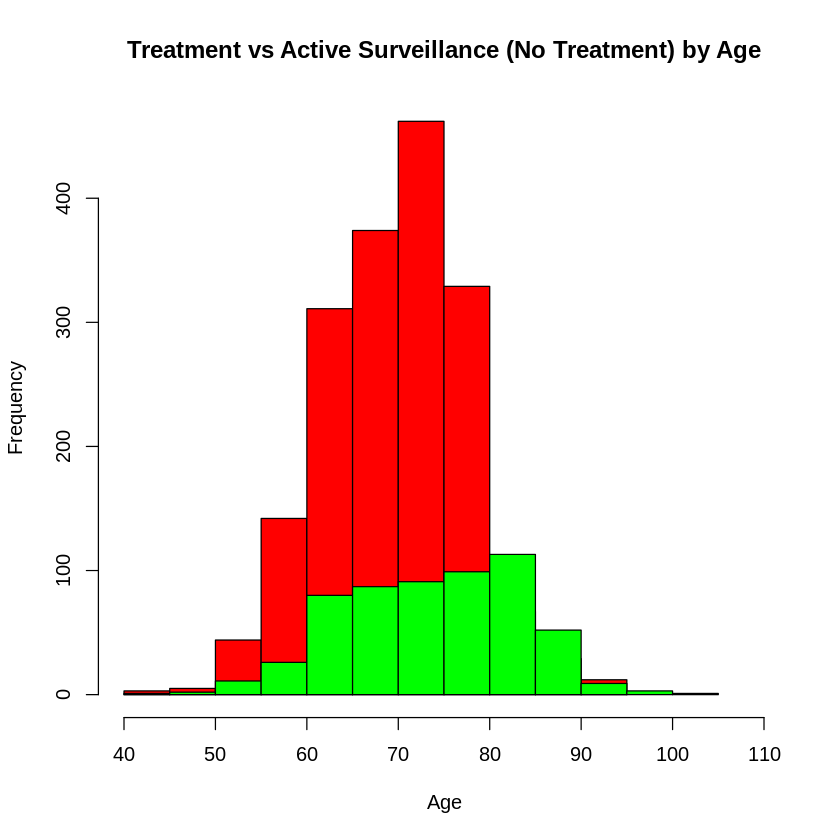

In [121]:
# plot histogram to illustrate the two distributions
hist(Q3_data$age_at_diagnosis[with(Q3_data, treatment == "Treatment")], xlim=c(40,110), 
     col="red", main="Treatment vs Active Surveillance (No Treatment) by Age", xlab="Age", ylab="Frequency")
hist(Q3_data$age_at_diagnosis[with(Q3_data, treatment == "Active_Surveillance")], add=T, col="green")

Question 3 Answer: Crosstabs illustrates the patient's age [of diagnosis] distribution by treatment. Initial Chi-square test of independence finds that the age distribution is associated with being on active surveillance, though sample size across groups were too small. A follow-up chi-square test of independence using simulated p-values, though, suggests age distribution is associated with being on active surveillance. Specifically, older patients [at the time of diagnosis] have a higher chance of being on active surveillance (no treatment).

Question 4: Using appropriate graphs and/or tables, investigate if there are any other strong associations between patient 
    characteristics. What, if anything, did you discover? [Spend no more than 20 minutes on this question].

In [137]:
# subset dataset by removing patient id and patient name
Dat <- filt_patients_data[,c(-1,-2)]

# Obtain chi-square distrbution of all combination of variables and return results as table
combos <- combn(ncol(Dat),2)

adply(combos, 2, function(x) {
  test <- chisq.test(Dat[, x[1]], Dat[, x[2]], simulate.p.value = TRUE)

  out <- data.frame("Row" = colnames(Dat)[x[1]]
                    , "Column" = colnames(Dat[x[2]])
                    , "Chi.Square" = round(test$statistic,3)
                    ,  "df"= test$parameter
                    ,  "p.value" = round(test$p.value, 3)
                    )
  return(out)

})  

X1,Row,Column,Chi.Square,df,p.value
1,sex,ethnicity,7.169,NA,0.121
2,sex,age_at_diagnosis,61.615,NA,0.133
3,sex,smoking_status,18.057,NA,0.000
4,sex,treatment,206.125,NA,0.000
5,sex,date_of_diagnosis,780.255,NA,0.774
6,sex,date_of_final_obs,1314.869,NA,0.092
7,sex,final_obs_status,1.449,NA,0.253
8,ethnicity,age_at_diagnosis,196.680,NA,0.658
9,ethnicity,smoking_status,11.893,NA,0.153
10,ethnicity,treatment,8.827,NA,0.701


Question 4 Answer: Running chi-square tests between all possible combinations of patient characteristics, there are very strong relationships (p < .005) between sex and smoking status, sex and treatment, age_at_diagnosis and smoking status, age_at_diagnosis and treatment, and date of diagnosis and date of final observation, and strong relationships (p <.05) between ethnicity and date of final observation, smokine status and treatment, smoking status and final observation status, and treatment and date of final observation. It should be noted that simulations were run due to small sample sizes. Fisher's exact test didn't work with the function.

# output took a while to run, so I saved the output here
X1	Row	Column	Chi.Square	df	p.value
1	sex	ethnicity	7.169	NA	0.121
2	sex	age_at_diagnosis	61.615	NA	0.133
3	sex	smoking_status	18.057	NA	0.000
4	sex	treatment	206.125	NA	0.000
5	sex	date_of_diagnosis	780.255	NA	0.774
6	sex	date_of_final_obs	1314.869	NA	0.092
7	sex	final_obs_status	1.449	NA	0.253
8	ethnicity	age_at_diagnosis	196.680	NA	0.658
9	ethnicity	smoking_status	11.893	NA	0.153
10	ethnicity	treatment	8.827	NA	0.701
11	ethnicity	date_of_diagnosis	3251.872	NA	0.297
12	ethnicity	date_of_final_obs	5282.791	NA	0.046
13	ethnicity	final_obs_status	1.033	NA	0.915
14	age_at_diagnosis	smoking_status	230.276	NA	0.005
15	age_at_diagnosis	treatment	521.454	NA	0.000
16	age_at_diagnosis	date_of_diagnosis	39156.770	NA	0.941
17	age_at_diagnosis	date_of_final_obs	65131.588	NA	0.739
18	age_at_diagnosis	final_obs_status	67.153	NA	0.140
19	smoking_status	treatment	14.355	NA	0.030
20	smoking_status	date_of_diagnosis	1354.568	NA	0.963
21	smoking_status	date_of_final_obs	2129.994	NA	0.997
22	smoking_status	final_obs_status	7.318	NA	0.025
23	treatment	date_of_diagnosis	2390.836	NA	0.523
24	treatment	date_of_final_obs	4202.393	NA	0.026
25	treatment	final_obs_status	9.284	NA	0.034
26	date_of_diagnosis	date_of_final_obs	1067682.835	NA	0.000
27	date_of_diagnosis	final_obs_status	742.733	NA	0.846
28	date_of_final_obs	final_obs_status	1237.548	NA	0.729

Question 5: What is the average amount charged for patients who are 65 years or older at diagnosis? Among those charged $100,000 or more, what proportion of the patients were 65 years or older at diagnosis?

In [222]:
# substring function to keep the numeric portion of the alphanumeric elements in patient_id from both datasets
RIGHT = function(x,n){
  substring(x,nchar(x)-n+1)
}

# rename patient_id characters
Q5_patients_data <- filt_patients_data
colnames(Q5_patients_data)[1] <- "patient_id"
Q5_patients_data$patient_id <- as.character(Q5_patients_data$patient_id)
Q5_patients_data$patient_id <- RIGHT(Q5_patients_data$patient_id, 8)

# rename patient_id characters
Q5_revenue_data <- revenue_data[,c(1,3)]
#aggregate charge_amount by patient_id into sum_charge_amount
Q5_revenue_data <- as.data.frame(aggregate(Q5_revenue_data$charge_amount, by=list(Q5_revenue_data$patient_id), FUN=sum))
colnames(Q5_revenue_data) <- c("patient_id", "sum_charge_amount") # rename columns
Q5_revenue_data$patient_id <- as.character(Q5_revenue_data$patient_id)
Q5_revenue_data$patient_id <- RIGHT(Q5_revenue_data$patient_id, 8)

# merge datasets together
merged_filtered_data <- merge.data.frame(Q5_patients_data, Q5_revenue_data, by="patient_id")

In [228]:
# Average amount charged for patients 65 years or older
mean(merged_filtered_data$sum_charge_amount[with(merged_filtered_data, age_at_diagnosis >= 65)])

[1] 88371.2

In [234]:
# filter dataset by patients charged over 100k
over_100k_data <- merged_filtered_data[merged_filtered_data$sum_charge_amount >= 100000, ]
# obtain proportion of those over 65 years of age
nrow(over_100k_data[over_100k_data$age_at_diagnosis >= 65, ])/nrow(over_100k_data)

[1] 0.8297872

Question 5 Answer: The average amount charged for patients who are 65 years or older at diagnosis is $88,371.20. Among those charged $100,100 or more, about 83% are patients who are 65 years or older at diagnosis.

Question 6: Dr. Dai is interested to see what factors if any are associated with the physician’s choice of targeted therapy vs. 
    chemotherapy. What, if anything, did you discover?

In [250]:
# subset dataset by filtering for treatment groups that are either chemotherapy or targeted therapy
sub_levels <- c("Chemotherapy","Targeted Therapy")
Q6_filtered_data <- merged_filtered_data[is.element(merged_filtered_data$treatment, sub_levels),]
Q6_filtered_data$treatment <- factor(Q6_filtered_data$treatment)

In [267]:
# run logistic regression
m1 <- glm(treatment ~ sex+ethnicity+age_at_diagnosis+smoking_status+date_of_diagnosis+sum_charge_amount, 
          data = Q6_filtered_data, family = 'binomial') # date_of_final_obs+final_obs_status
summary(m1) # summary output


Call:
glm(formula = treatment ~ sex + ethnicity + age_at_diagnosis + 
    smoking_status + date_of_diagnosis + sum_charge_amount, family = "binomial", 
    data = Q6_filtered_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0760  -0.9131  -0.5333   1.0064   2.2435  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -1.071e+01  1.818e+00  -5.889  3.9e-09 ***
sexmale                       -1.525e+00  1.134e-01 -13.447  < 2e-16 ***
ethnicityBlack (not Hispanic) -2.202e-01  2.171e-01  -1.014    0.310    
ethnicityHispanic             -1.354e-01  1.813e-01  -0.747    0.455    
ethnicityNative American      -4.783e-01  3.653e-01  -1.309    0.190    
ethnicityWhite (not Hispanic) -9.531e-02  1.460e-01  -0.653    0.514    
age_at_diagnosis              -8.173e-02  7.686e-03 -10.634  < 2e-16 ***
smoking_statusnon-smoker       7.497e-01  5.609e-01   1.336    0.181    
smoking_statussmoker          -4

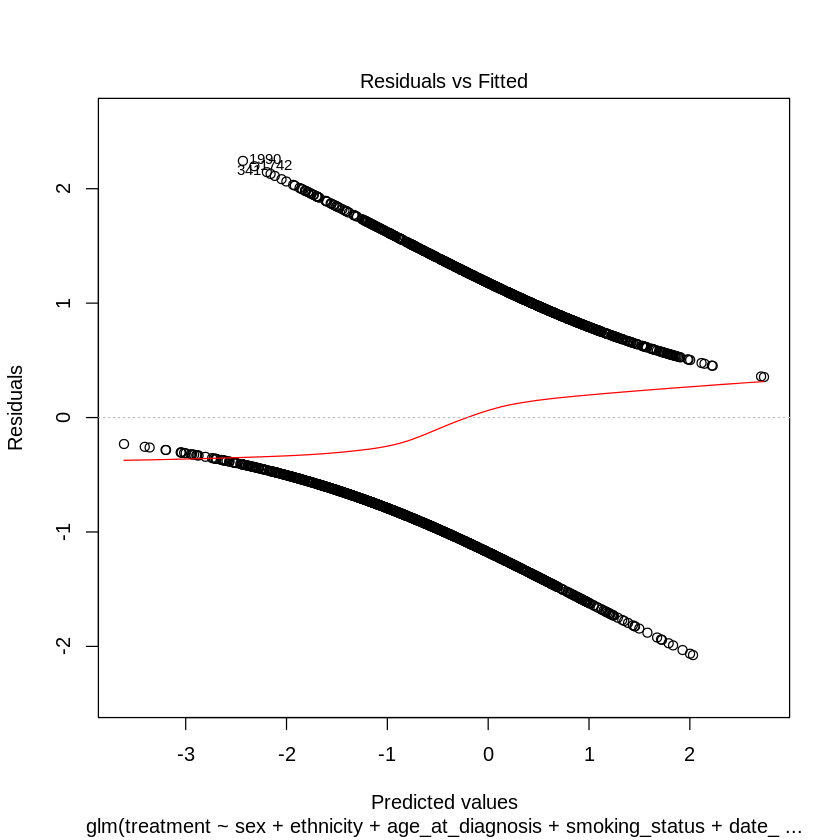

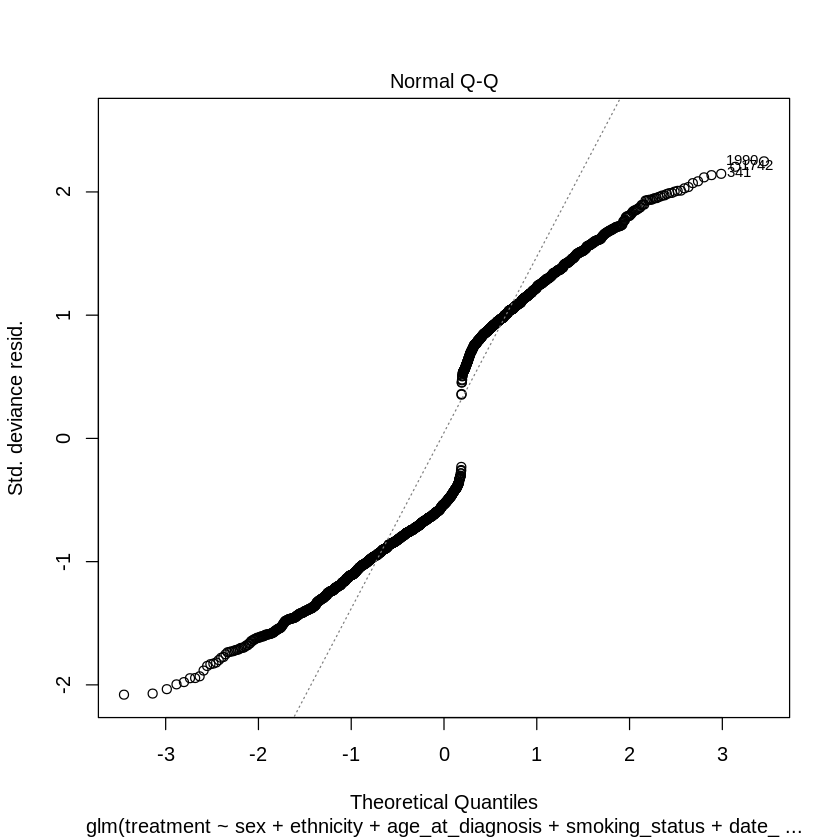

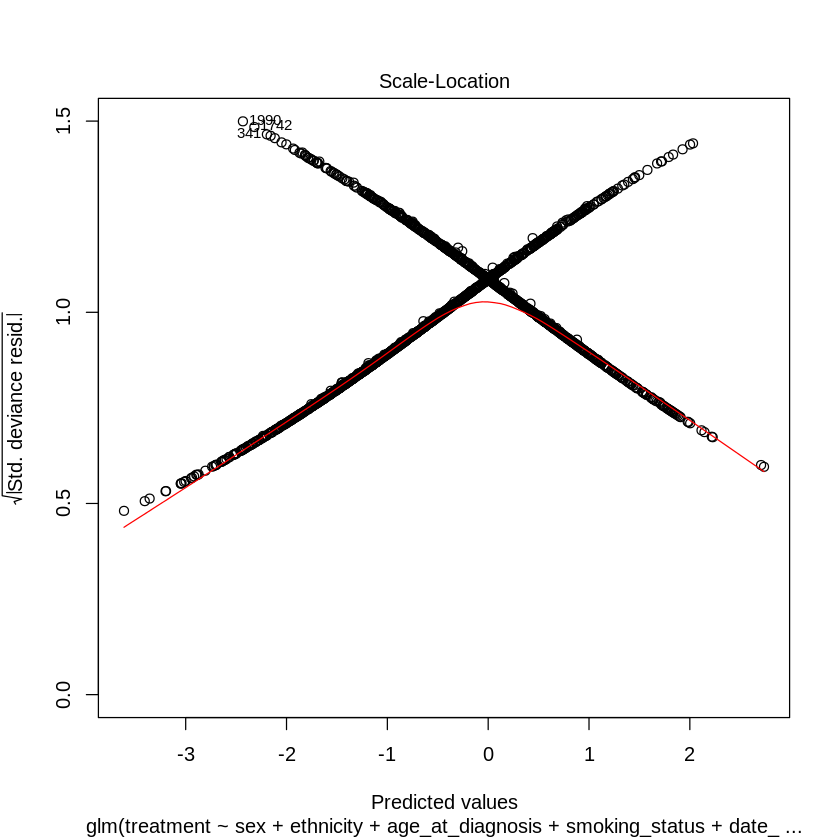

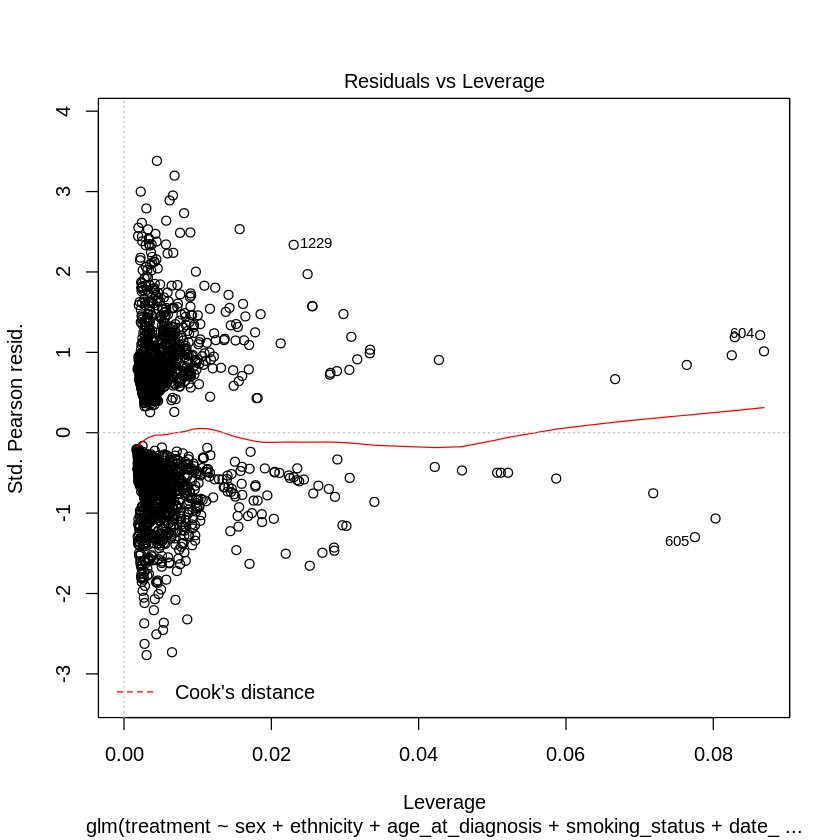

In [277]:
plot(m1) # plot observed vs expected observations and residuals

Question 7: What is the median time to death in the sample? (For questions 6,7, and 8: time is measured from the date of diagnosis)

In [286]:
# filter dataset to include patients who expired
Q7_data <- merged_filtered_data[merged_filtered_data$final_obs_status == 'expired', ]

# calculate time difference between date of final observation and date of diagnosis among those who died
Q7_data$time_to_death <- difftime(Q7_data$date_of_final_obs, Q7_data$date_of_diagnosis, unit = "day")

# obtain median time
median(Q7_data$time_to_death) # 2.93634497 years

Time difference of 1072.5 days

Question 7 Answer: Among the sample who expired, the median time to death is 1072.5 days (or ~2.94 years).

Question 8: What is the probability that a patient will be alive for at least 1 year?

In [309]:
# create new dataset object for question, obtain time difference variable
Q8_data <- merged_filtered_data
Q8_data$time_to_death <- difftime(Q8_data$date_of_final_obs, Q8_data$date_of_diagnosis, unit = "day")

# fit time_to_death and status into survival curve from survival library to obtain model output
m2 <- survfit(Surv(Q8_data$time_to_death, Q8_data$final_obs_status)~1)
summary(m2) # output summary of survival model

Call: survfit(formula = Surv(Q8_data$time_to_death, Q8_data$final_obs_status) ~ 
    1)

 time n.risk n.event P(expired)      P()
   12   2369       1   0.000422 0.999578
   13   2368       2   0.001266 0.998734
   15   2366       1   0.001688 0.998312
   16   2365       1   0.002111 0.997889
   17   2364       1   0.002533 0.997467
   19   2363       2   0.003377 0.996623
   27   2361       1   0.003799 0.996201
   32   2360       1   0.004221 0.995779
   33   2359       1   0.004643 0.995357
   36   2358       1   0.005065 0.994935
   38   2357       2   0.005910 0.994090
   40   2355       1   0.006332 0.993668
   41   2354       1   0.006754 0.993246
   42   2353       1   0.007176 0.992824
   43   2352       1   0.007598 0.992402
   48   2351       1   0.008020 0.991980
   49   2350       1   0.008442 0.991558
   50   2349       1   0.008864 0.991136
   52   2348       2   0.009709 0.990291
   57   2346       1   0.010131 0.989869
   58   2345       1   0.010553 0.989447
   59   2

In [328]:
# obtain the summary() of the probability of survival after one year from vector column for all patients
summary(as.data.frame(summary(m2)$pstate)[2])

       V2        
 Min.   :0.0000  
 1st Qu.:0.2153  
 Median :0.4742  
 Mean   :0.4815  
 3rd Qu.:0.7415  
 Max.   :0.9996  

In [ ]:
Q8 Answer: On average, there is a 48% probability that a patient will be alive after 1 year.

Q9 Question: Is survival different for patients treated with chemotherapy vs. patients treated with targeted therapy?

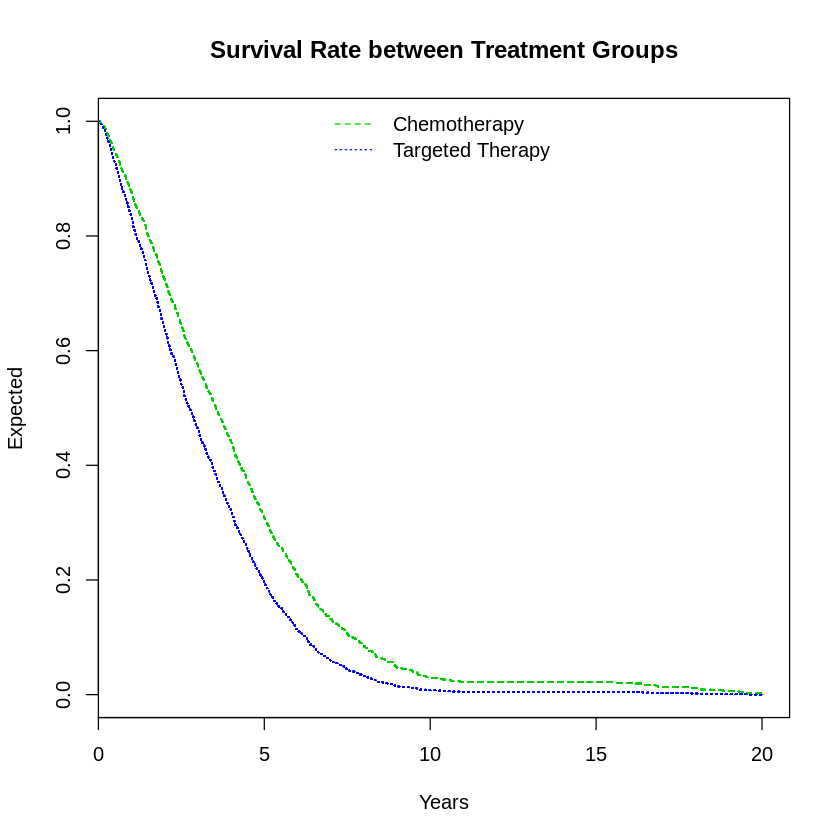

In [448]:
# subset dataset by filtering for treatment groups that are either chemotherapy or targeted therapy
sub_levels <- c("Chemotherapy","Targeted Therapy")
# filter dataset
Q9_data <- merged_filtered_data[is.element(merged_filtered_data$treatment, sub_levels),]
# collapses factor levels that are empty
Q9_data$treatment <- factor(Q9_data$treatment)
# preprocess column for survival analysis
Q9_data$final_obs_status_num <- as.numeric(Q9_data$final_obs_status)
# obtain time difference variable
Q9_data$time_to_death <- difftime(Q9_data$date_of_final_obs, Q9_data$date_of_diagnosis)

# obtain and fit cox model of time_to_death and final status by treatment to observed and plot results
m3 <- coxph(Surv(time_to_death, final_obs_status_num) ~ treatment, data = Q9_data) 
temp <- data.frame(treatment=levels(Q9_data$treatment), sex=levels(Q9_data$sex), 
                   age_at_diagnosis=Q9_data$age_at_diagnosis, date_of_diagnosis=Q9_data$date_of_diagnosis)
expfit <- survfit(m3, temp)
plot(expfit, xscale=365.25, ylab="Expected", xlab="Years", main="Survival Rate between Treatment Groups",
     lty = 2:3,col=3:4)
lLab <- gsub("x=","", levels(Q9_data$treatment))  ## legend labels
legend("top", legend=lLab, lty=2:3, col=3:4, horiz=FALSE, bty='n')

In [451]:
# run anova of cox model to compare treatment groups
anova(m3)
summary(m3)

,loglik,Chisq,Df,Pr(>|Chi|)
NULL,-10880.89,NA,NA,NA
treatment,-10859.30,43.19326,1,4.959111e-11


Call:
coxph(formula = Surv(time_to_death, final_obs_status_num) ~ treatment, 
    data = Q9_data)

  n= 1778, number of events= 1679 

                             coef exp(coef) se(coef)     z Pr(>|z|)    
treatmentTargeted Therapy 0.32863   1.38906  0.04955 6.632 3.31e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                          exp(coef) exp(-coef) lower .95 upper .95
treatmentTargeted Therapy     1.389     0.7199      1.26     1.531

Concordance= 0.547  (se = 0.007 )
Rsquare= 0.024   (max possible= 1 )
Likelihood ratio test= 43.19  on 1 df,   p=4.959e-11
Wald test            = 43.98  on 1 df,   p=3.313e-11
Score (logrank) test = 44.37  on 1 df,   p=2.72e-11


Q9 Answer: Yes, survival is different for patients treated with chemotherapy vs. patients treated with targeted therapy. Generally, patients under chemotherapy are ~1.39 times more likely to live longer than patients treated with target therapy, though the difference in probability between the two treatment groups varies across time. For example, according to the plot, at five years the expected survival rate for individuals under chemotherapy is ~30% while those under targeted therapy is ~30%.